In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

from prob_rob.motion_models import OdometryMotionModel
from prob_rob.data import read_simple_world, read_simple_data
from prob_rob.utils import normalize_angle, sample_normal_distribution
from prob_rob.robot import BaseRobot
from prob_rob.map import LandmarkMap

In [76]:
class EKFSLAMKnown:
    def __init__(self, pose, num_landmarks, motion_model=None):
        # Main estimate
        
        landmark_pose = np.zeros((2*num_landmarks, 1))
        
        self.mean = np.concatenate((np.copy(pose), landmark_pose))
        self.cov = np.zeros((self.mean.size, self.mean.size))
        lm_cov = np.eye(2*num_landmarks)
        np.fill_diagonal(
            lm_cov,
            10**10
        )
        self.cov[3:, 3:] = lm_cov
        
        # Intermediate variables
        self._mean = np.copy(self.mean)
        self._cov = np.copy(self.cov)

        self.motion_model = motion_model

    def predict(self, command):
        robot_pose = self.mean[:3, :]
        self._mean[:3, :] = self.motion_model.command_static(
            robot_pose, 
            command
        )

        # TODO: Put in motion model
        theta_n = normalize_angle(self.mean.item(2))
        rot1, trans, rot2 = command

        ang = normalize_angle(theta_n + rot1)
        Gtx = np.matrix([
            [1, 0, - trans * math.sin(ang)],
            [0, 1, trans * math.cos(ang)],
            [0, 0, 1],
        ])
        
        lmsize = self.mean.shape[0] - 3
        
        r1zeros = np.zeros((3, lmsize))
        r2zeros = np.copy(r1zeros.T)
        
        gr1 = np.concatenate( (Gtx, r1zeros), axis=1 )
        gr2 = np.concatenate( (r2zeros, np.eye(lmsize)), axis=1)
        Gt = np.concatenate((gr1, gr2))
        
        # motion noise
        Rtx = np.matrix([
            [0.1, 0, 0],
            [0, 0.1, 0],
            [0, 0, 0.01]
        ])
        
        rr1zeros = np.zeros((3, lmsize))
        rr2zeros = np.copy(rr1zeros.T)
        
        rr1 = np.concatenate(
            (Rtx, rr1zeros), 
            axis=1
        )
        rr2 = np.concatenate( 
            (rr2zeros, np.zeros((lmsize, lmsize))),
            axis=1
        )
        Rt = np.concatenate((rr1, rr2))
        
        self._cov = Gt * self.cov * Gt.T + Rt
        
        return self._mean, self._cov

    def correct(self, measurements, local_map):
        # measurement noise
        Qt = np.eye(self.mean.size)
        Qt[:3, :3] = Qt[:3, :3] * 0.01
        Qt[3:, 3:] = Qt[3:, 3:] * 0
        
        rx = self._mean.item(0)
        ry = self._mean.item(1)
        rtheta = normalize_angle(self._mean.item(2))

        for reading in measurements:
            # TODO: Put in measurement model
            lid, srange, sbearing = reading
            z_measured = np.matrix([srange, normalize_angle(sbearing)]).T
            
            mu_lid = 3 + 2*(lid - 1)

            # Expected observation
            lx = 0
            ly = 0
            if not local_map.is_added(lid):
                lx = rx + srange * math.cos(normalize_angle(sbearing + rtheta))
                ly = ry + srange * math.sin(normalize_angle(sbearing + rtheta))
                local_map.add((lid, lx, ly))
                self._mean[mu_lid,:] = lx
                self._mean[mu_lid+1, :] = ly
            else:
                lx = self._mean[mu_lid,:]
                ly = self._mean[mu_lid+1,:]
                
            dx = lx - rx
            dy = ly - ry
            delta = np.matrix([dx, dy]).T
            q = delta.T * delta
            z_expected = np.matrix([
                math.sqrt(q),
                normalize_angle(np.arctan2(dy, dx) - rtheta)
            ]).T
            # Jacobian
            qst = math.sqrt(q)
            # robot pose
            Hrp = np.matrix([
                [-qst * dx, -qst * dy, 0],
                [dy, -dx, -q]
            ])
            # landmark
            Hlm = np.matrix([
                [qst * dx, qst * dy],
                [-dy, dx]
            ])
            
            Hrp = np.multiply((1.0 / q), Hrp)
            Hlm = np.multiply((1.0 / q), Hlm)
            # TODO: Make this matrix
            Ht = np.eye(self._mean.size) * 10

            Kgain = self._cov * Ht.T * np.linalg.inv(Ht * self._cov * Ht.T + Qt)

            diff = z_measured - z_expected
            diff[1] = normalize_angle(diff.item(1))
            
            # Is this correct?
            diff_h = np.zeros((self._mean.size, 1))
            diff_h[mu_lid:mu_lid+2, :] = diff
            
            self._mean = self._mean + Kgain * diff_h
            self._cov = (np.eye(self._mean.size) - Kgain * Ht) * self._cov

        self.mean = np.copy(self._mean)
        self.cov = np.copy(self._cov)

        return self.mean, self.cov

ValueError: matrix must be 2-dimensional

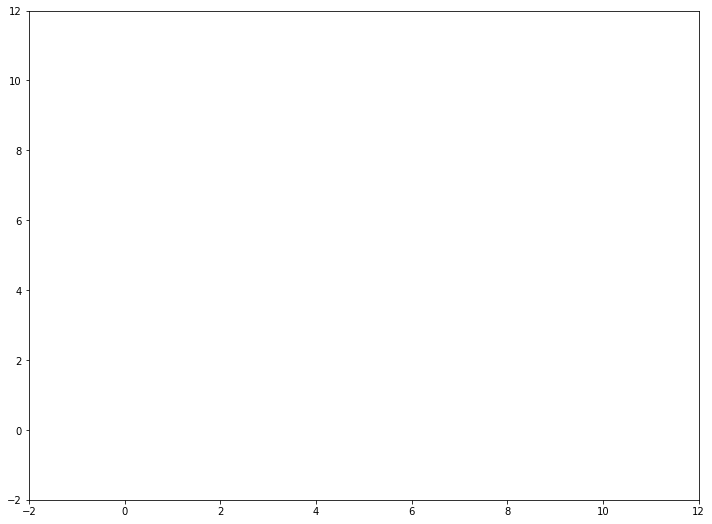

In [77]:
robot = BaseRobot(0, 0, 0)
motion_model = OdometryMotionModel(robot.pose)
robot.motion = motion_model

odometry, sensor = read_simple_data('./data/simple/sensor_data.dat')
landmarks = read_simple_world('./data/simple/world.dat')

landmark_map = LandmarkMap([])
commands = [np.array(odom).T for odom in odometry]

num_landmarks = len(landmarks)
EKF = EKFSLAMKnown(robot.pose, num_landmarks, motion_model)

# Plot true robot path
x = []
y = []
EKF_x = []
EKF_y = []
cov_dets = []
landmark_x = []
landmark_y = []

plt.figure(figsize=(12, 9), )
plt.xlim((-2, 12))
plt.ylim((-2, 12))

for command, readings in zip(commands, sensor):  
    # True path
    robot.motion_command(command)
    x.append(robot.pose.item(0))
    y.append(robot.pose.item(1))
    
    EKF.predict(command)
    
    EKF.correct(readings, landmark_map)
    
    #EKF.mean = np.copy(EKF._mean)
    #EKF.cov = np.copy(EKF._cov)
    
    EKF_x.append(EKF.mean[:3, :].item(0))
    EKF_y.append(EKF.mean[:3, :].item(1))
    cov_dets.append(np.linalg.det(EKF.cov))
    
for key, value in landmark_map.landmarks.items():
    landmark_x.append(value[0])
    landmark_y.append(value[1])    
    
plt.plot(x, y, 'g', zorder=1, label='GT path')    
plt.plot(EKF_x, EKF_y, 'bx', markersize=5, zorder=2, label='EKF estimation')
plt.plot(landmark_x, landmark_y, 'ro', zorder=0, label='Landmarks')
plt.legend()

plt.figure()
plt.plot(cov_dets)

(19L,)